---
title: "Notebook: Analysis of Unsupervised Denoising Methods"

description: "Overview of the current state of image denoising. Investigating traditional and deep learning methods."

author:
  - name: Sam Herold
  
    url: https://samhero16.github.io/
    
    orcid: 0000-0002-5300-3075



image: cs445.png

draft: false

date: 2024-05-17

---


# Introduction

### **Abstract**

Image denoising is a classic problem in computer vision and image processing. The goal is simple: to remove noise from a noisy image and recover the underlying image. The problem statement is often written as x ̂=x+n, where x ̂  is the observed image, n is additive noise and x is the ground truth image that we hope to recover. Often times, we do not have access to any x (ground truth) images, making the problem unsupervised. There are many ways people have attempted to do unsupervised denoising, and I will be exploring the most popular in this paper.

### **Background**

Noisy images are very prevalent in engineering, biology, and many other areas, making denoising very important and heavily researched. I was introduced to the world of image denoising during an undergraduate research project in the Department of Electrical Engineering, with Dr.  Jesse Wilson and his lab. Their new laser scan technology produces biomedical images that contain a significant amount of noise. Their images will always contain noise (due to the electronics, the nature of light, laser exposure limits, etc.), meaning there is no access to any ground truth images ever. This led to questions about unsupervised denoising options.

The labs current approach is stack averaging (taking multiple images of the same thing, then averaging them). This method is consistent, but costly, slow, and can damage the sample. This begged for an instant denoising method. My research task was to investigate the deep learning Noise2Noise framework. I will discuss this method later on in this paper.  

My goal with this paper is to investigate unsupervised denoisers, both traditional and in deep learning, and try them on some biomedical data from the lab.

### **Dataset Notes**

I will be trying some of these methods on the noisy images collected from Dr. Jesse Wilson’s lab. These are collected in stacks (collections of image with the same underlying image, but with different noise instances). They are 128x128 grayscale images, who’s pixel values are centered around zero, not between 0 and 255. We also believe the noise on the images is additive and gaussian. The noise level is very high on these images.

For understanding the output of the different denoisers, we will compare their outpurs to the stack averages, both visually and using MSE. The stack average is certainly not the ground truth, but the best that we can do and shows us at least some of the true underlying structure. The MSE definetely does not make or break the ability of the denoiser, it is just gives us some kind of slight reference.

### **Load dependencies, load data, and create helper methods**

In [9]:
#dependencies
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import wiener
import cv2

import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler

import io
import tensorflow as tf
import n2v
from n2v.models import N2VConfig, N2V
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

In [86]:
#load
X = []
a = [] #averages
path = "/content/gdrive/MyDrive/CS445Final/2023-08-30-FullDataSet"
XFull = []

#loop through folder containing tifs
for image_class in os.listdir(path):
      average = np.zeros([128,128])
      sameBaseImages = []
      #open tif file
      image_path = os.path.join(path, image_class)
      tif = Image.open(image_path)
      X.append(np.array(tif))#just add one from each stack
      #loads images for stack average
      for i in range(tif.n_frames):
          tif.seek(i)
          img = np.array(tif)
          XFull.append(img)
          average += img

      a.append(average/tif.n_frames)

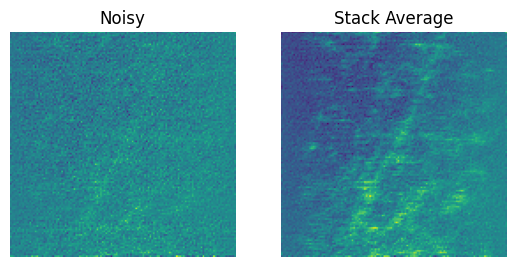

Example of noisy image and its corresponding stack average, the closest to ground truth that we can get.  


In [88]:
plt.subplot(121)
plt.axis('off')
plt.imshow(X[0])
plt.title('Noisy')
plt.subplot(122)
plt.axis('off')
plt.title('Stack Average')
plt.imshow(a[0])
plt.show()
print('Example of noisy image and its corresponding stack average, the closest to ground truth that we can get.  ')

In [29]:
def plot(original, denoised,average, title):
    print("MSE (denoised vs average): " , round(np.mean((denoised - average)**2),5))
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(denoised)
    plt.title(title)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(average)
    plt.title('Average Stack')
    plt.axis('off')
    plt.show()
    plt.show()




---



---




# Investigating Denoisers
### **Linear Filtering**

[Fan et al., 2019]

Linear filtering is the most straightforward way to denoise. This method involves sliding a moving window or kernel over each pixel in the image. Some operation is done on that window (i.e. mean, median), and the center pixel is replaced with the outcome of that operation. All of these filters have hyperparameters that you can tune for your images. In the following examples, I tuned the hyperparamters by hand until the outputs were as optimal as they could be.

*Mean Filter*: Take the mean of every surrounding pixel in the kernel and replace the center pixel with the mean.

*Median Filter*: Take the median of every surrounding pixel in the kernel and replace the center pixel with the mean.

*Gaussian Filter*: Uses a gaussian kernel for convolution. Uses a wieghted average of the kernel that is determined by the gaussian distribution. Smooths the image well (think of gaussian blur from photoshop).

*Weiner Filter*: The wiener filter uses the frequency domain. It is complicated and uses Fourier Transforms.

#### Mean Filtering

MSE (denoised vs average):  0.00546


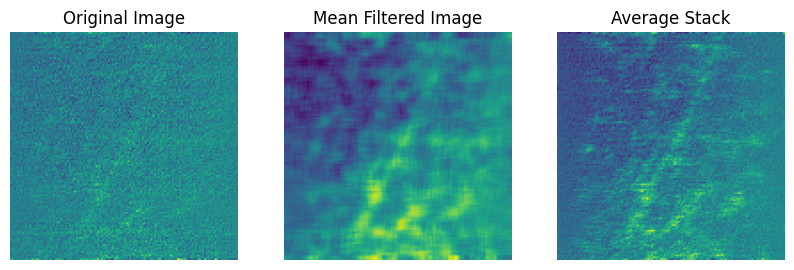

MSE (denoised vs average):  0.00617


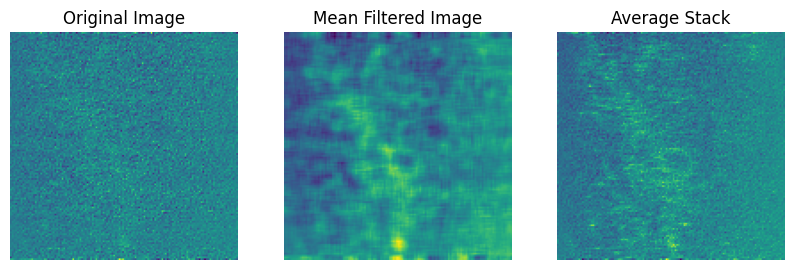

In [89]:
kernel = (6, 6)
filtered = ndimage.uniform_filter(X[0], size=kernel)
plot(X[0], filtered, a[0],  'Mean Filtered Image')

filtered = ndimage.uniform_filter(X[1], size=kernel)
plot(X[1], filtered, a[1], 'Mean Filtered Image')

#### Median Filtering

MSE (denoised vs average):  0.00756


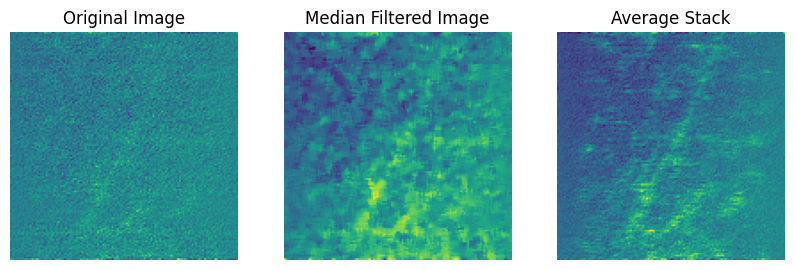

MSE (denoised vs average):  0.00852


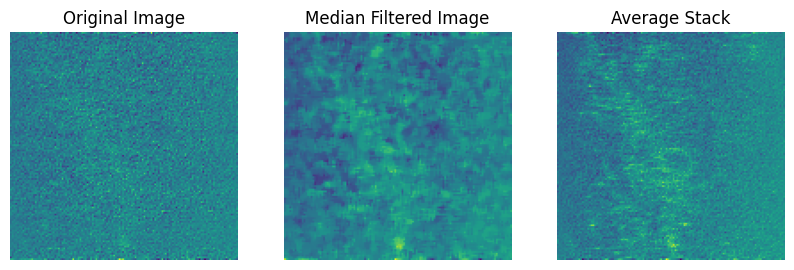

In [50]:
filtered = ndimage.median_filter(X[0], size=4)
plot(X[0], filtered, a[0],'Median Filtered Image')

filtered = ndimage.median_filter(X[1], size=4)
plot(X[1], filtered, a[1],'Median Filtered Image')

#### Gaussian Filtering

MSE (denoised vs average):  0.00504


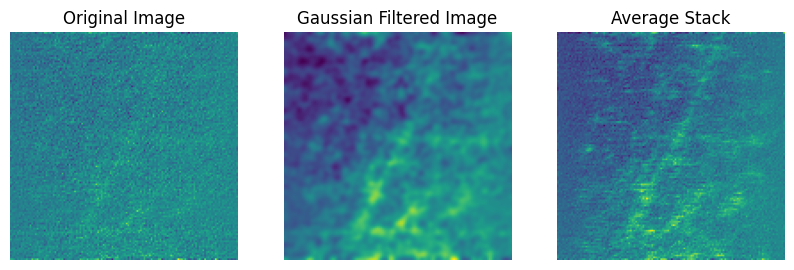

MSE (denoised vs average):  0.00579


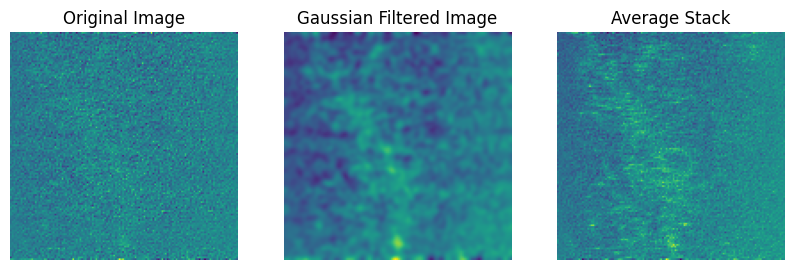

In [82]:
filtered = ndimage.gaussian_filter(X[0], sigma = 1.5)
plot(X[0], filtered, a[0],'Gaussian Filtered Image')

filtered = ndimage.gaussian_filter(X[1], sigma = 1.5)
plot(X[1], filtered, a[1],'Gaussian Filtered Image')

#### Wiener Filtering

MSE (denoised vs average):  0.00765


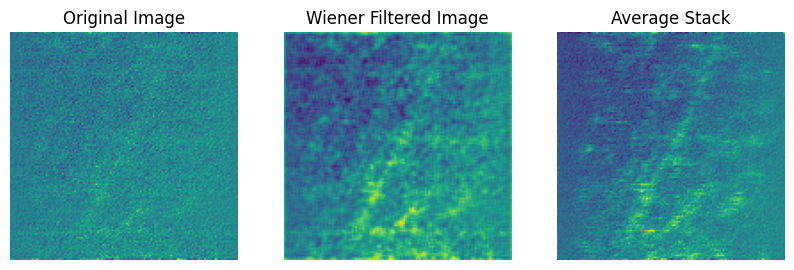

MSE (denoised vs average):  0.00858


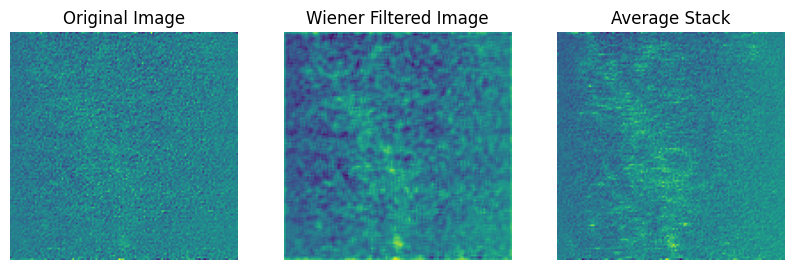

In [55]:
filtered = wiener(X[0],noise = 5)
plot(X[0], filtered,a[0], 'Wiener Filtered Image')

filtered = wiener(X[1],noise = 5)
plot(X[1], filtered, a[1],'Wiener Filtered Image')

#### Pros:
- Simple to understand.
- Simple to implement.
- Only need one image.
- Sensitive to hyperparameters.
- Versatile.

#### Cons:
- Poor performance.
- Only uses local information.
- Only can use one image even if others are available.
- Bad with edges.

The gaussian filter looks very promising. I will comment more on this in the conclusion.



---



---


### **Other Filters**

[Fan et al., 2019]


These methods up the complexity and use information from the whole image. This increases performance and edge preservation. Also, these methods require that I put the images between 1 and 255. This isnt so much a downside, but rather an inconvienience as it changes the scale of the MSE.

*Non-Local Means*: Uses patches of similar makeup from other parts of the image for averaging a window. This average is weighted by how similar the image patches are.

*Bilateral Filtering*: Uses a weighted average where spatial distance and pixel intensity are considered in weighting.

#### Non-Local Means

MSE (denoised vs average):  97.04028


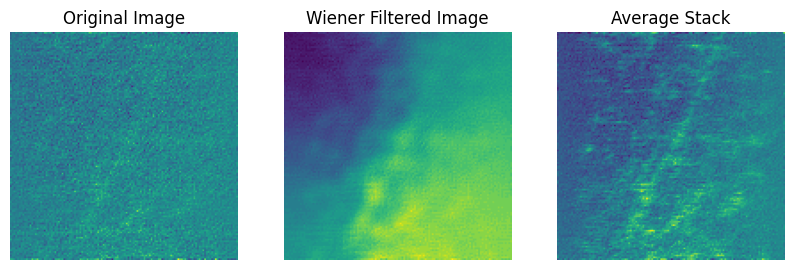

MSE (denoised vs average):  89.83875


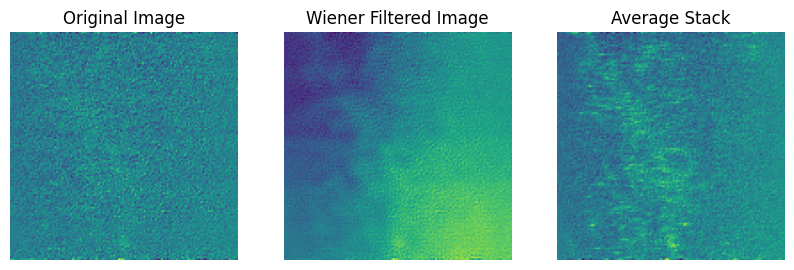

In [57]:
normalized = ((X[0]  - X[0] .min()) / (X[0] .max() - X[0] .min()) * 255).astype(np.uint8) #we need to normalize for cv2 to be able to function
ave = ((a[0]  - a[0] .min()) / (a[0] .max() - a[0] .min()) * 255).astype(np.uint8) # also need to do this for averages
NL = cv2.fastNlMeansDenoising(normalized, None, h=18, templateWindowSize=9, searchWindowSize=100)
plot(X[0], NL, ave, 'Wiener Filtered Image')

normalized = ((X[1]  - X[1] .min()) / (X[1] .max() - X[1] .min()) * 255).astype(np.uint8)
ave = ((a[1]  - a[1] .min()) / (a[1] .max() - a[1] .min()) * 255).astype(np.uint8)
NL = cv2.fastNlMeansDenoising(normalized, None, h=18, templateWindowSize=9, searchWindowSize=100)
plot(X[1], NL, ave,'Wiener Filtered Image')

#### Bilateral filtering

MSE (denoised vs average):  95.36255


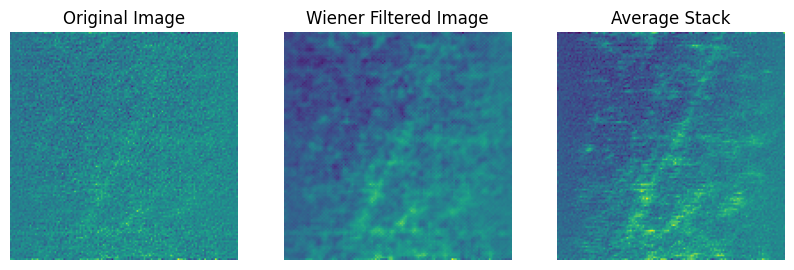

MSE (denoised vs average):  87.04791


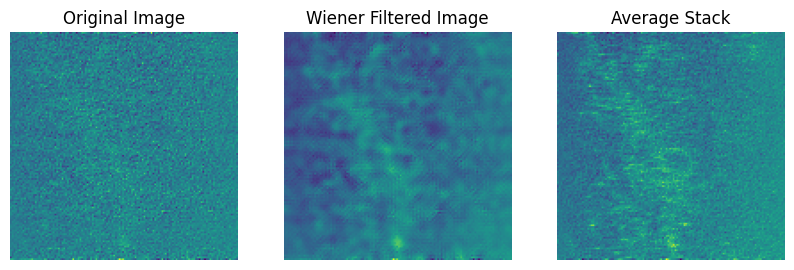

In [58]:
normalized = ((X[0]  - X[0] .min()) / (X[0] .max() - X[0] .min()) * 255).astype(np.uint8)
bilateral = cv2.bilateralFilter(normalized, d=4, sigmaColor=75, sigmaSpace=75)
ave = ((a[0]  - a[0] .min()) / (a[0] .max() - a[0] .min()) * 255).astype(np.uint8)
plot(X[0], bilateral, ave,'Wiener Filtered Image')

normalized = ((X[1]  - X[1] .min()) / (X[1] .max() - X[1] .min()) * 255).astype(np.uint8)
bilateral = cv2.bilateralFilter(normalized, d=6, sigmaColor=75, sigmaSpace=75)
ave = ((a[1]  - a[1] .min()) / (a[1] .max() - a[1] .min()) * 255).astype(np.uint8)
plot(X[1], bilateral, ave, 'Wiener Filtered Image')


#### Pros:
- Simple to implement.
- Increased complexity over simple filtering.
- Require only one image.
- Versatile.
- Can pick up on detail.

#### Cons:
- Decently complex to understand.
- Very sensitive to its parameters.
- Struggles with edge preservation.
- Might create blurring/artifacts.
- Definetly does not smooth the image.




---



---



### **BM3D**
'Block Matching 3D Filtering' is a complex, state of the art denoising technique. This technique builds upon non-local means, in the sense that  the algorithm groups similar patches using a block matching algorithm. These groups are then filtered an aggregated to produce the final image. BM3D is widely recognized to be one of the best options for denoising. It is easily avaible in the 'bm3d' package:

In [6]:
!pip install bm3d;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00


In [84]:
import bm3d
from skimage import io, img_as_float32

The main hyperparameter for bm3d is sigma: this is supposed to be the standard deviation of the noise. I could not figure out how to find this with no ground truth, so I tried many different sigmas to see which one had the visually best result. The resulting sigma was 45.

MSE (denoised vs average):  2422.69757


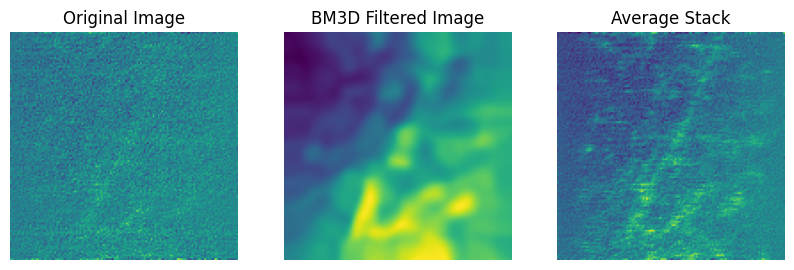

MSE (denoised vs average):  1621.71947


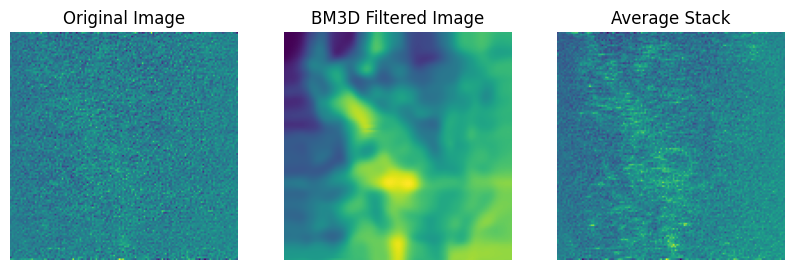

MSE (denoised vs average):  1216.8787


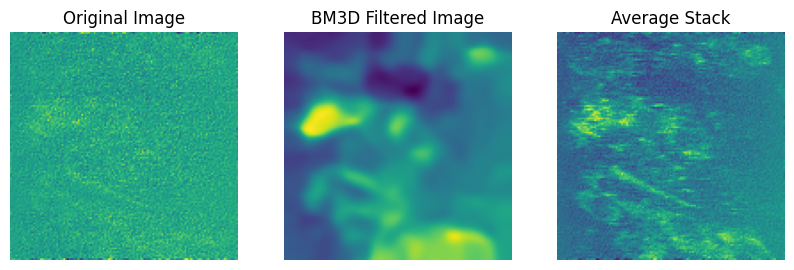

In [85]:
s = 45

image = io.imread('/content/gdrive/MyDrive/CS445Final/Png2/20230830_15_40_14.png', as_gray = True)
bm3dout = bm3d.bm3d(image, sigma_psd = s , stage_arg = bm3d.BM3DStages.ALL_STAGES)
ave = ((a[0]  - a[0] .min()) / (a[0] .max() - a[0] .min()) * 255).astype(np.uint8)
plot(X[0],bm3dout, ave, 'BM3D Filtered Image')

image = io.imread('/content/gdrive/MyDrive/CS445Final/Png2/20230830_16_01_28.png', as_gray = True)
bm3dout = bm3d.bm3d(image, sigma_psd = s, stage_arg = bm3d.BM3DStages.ALL_STAGES)
ave = ((a[1]  - a[1] .min()) / (a[1] .max() - a[1] .min()) * 255).astype(np.uint8)
plot(X[1],bm3dout,ave, 'BM3D Filtered Image')

image = io.imread('/content/gdrive/MyDrive/CS445Final/Png2/20230830_16_01_54.png', as_gray = True)
bm3dout = bm3d.bm3d(image, sigma_psd = s, stage_arg = bm3d.BM3DStages.ALL_STAGES)
ave = ((a[2]  - a[2] .min()) / (a[2] .max() - a[2] .min()) * 255).astype(np.uint8)
plot(X[2],bm3dout, ave, 'BM3D Filtered Image')

BM3D does not seem to be the most effective for this particular problem. I think visually it gives some decent results, but wierdly the MSE is really large. It definetely makes the image smooth and 'not noisy', but it misses a ton of detail in exchange. Everything I read says that it is probably one if not the best option for denoising a single image, so I do not count it out.


Pros:
- Good performance.
- Easy to implement and use.
- Uses non-local imformation.
- Versatile and robust.
- Only requires on image.

Cons:
- Sensitive to hyperparameters..
- Can take a long time for some images.
- May miss out on some fine detail structure.
- Mainly good at denoising additive gaussian.
- Not available on Mac Silicon (this was frustrating).





---



---



### **Noise2Noise**

[Lehtinen et al., 2018]

It is seemingly obvious that a neural network could learn to denoise images if trained on noisy input images with clean targets (the network learns how to go from noisy to clean). Call this Noise2Clean. However, it is often difficult, costly or impossible to get clean image targets. Noise2Noise is a deep learning framework that uses only noisy images to denoise images, and rivals the performance of the aforementioned noisy to clean method. This framework was proposed in NVidias 2018 paper, “Noise2Noise: Learning Image Restoration without Clean Data.”

Noise2Noise uses noisy images as both the model input and the target. Through an interesting realization in math, this is essentially the same as using a clean image target. The model will try to predict the noisy target and fail. The best that it can do (while still reducing training loss) is predict the underlying, clean image.

Another way to think about it is with gradients. The gradient does not point exactly to the clean image, but rather many gradients point to images that average to the underlying clean images. In other words, the average gradient points to the unobserved clean image. In theory, the model will converge to the expected value of the noisy image.

![image-2.png](Oreaq8x.png)

[Lehtinen et al., 2018]

There are some serious benefits to using Noise2Noise. If you have noisy image pairs, this will likely give the best denoising that you can ask for. Unlike the denoisers seen before this, this model can use information from multiple images. Just based off that, it makes sense that this framework will outperform algorithms that use just one image.


Noise2Noise uses a U-NET architecture. Essentially, U-NET is an image to image convolutional neural network. The inputs and outputs are both images.

![image-3.png](1_f7YOaE4TWubwaFF7Z1fzNw.png)


[Ronneberger et al., 2015]

As you can see, UNET gets its name from its shape. In essence, it squeezes images down (encoding) to extract information, then builds them back up (decoding) to predict the target. The encoder section is a series of convolutional and max-pooling layers, and the decoder is a series of up sampling layers. Another important aspect of UNET is its skip connections (arrows across the top). These basically give the decoder some information about the structure at different stages of encoding that it can use if needed. Learning about upsampling, maxpooling and skip connections were all new to me and are super cool.

- Encoder
    - Convolutional layer(s) followed by max pooling layer
    - Extracts and separates information
- Decoder
    - Convolutional layer and transpose convolutional layer.
    - Up samples feature maps and combines them to predict the final image.
- Skip Connections
    - Connect layers of the the encoder to layers of the decoder
    - Provide information that may be useful information from earlier layers.
    - This makes extra sense for Noise2Noise, as the target image is very similar to the input image.


Below is an implementation of the UNET (in pytorch) used in Noise2Noise. This was taken from the Noise2Noise github page. This is a fairly complex model as you can see.


In [ ]:
#Unet pulled from Noise2Noise Github Repo [Lehtinen et al., 2018], [Ronneberger et al., 2015]
class UNet(nn.Module):
    """Custom U-Net architecture for Noise2Noise (see Appendix, Table 2)."""

    def __init__(self, in_channels=1, out_channels=1):
        """Initializes U-Net."""

        super(UNet, self).__init__()

        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))

        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()


    def forward(self, x):
        """Through encoder, then decoder by adding U-skip connections. """

        # Encoder
        pool1 = self._block1(x)
        pool2 = self._block2(pool1)
        pool3 = self._block2(pool2)
        pool4 = self._block2(pool3)
        pool5 = self._block2(pool4)

        # Decoder
        upsample5 = self._block3(pool5)
        concat5 = torch.cat((upsample5, pool4), dim=1)
        upsample4 = self._block4(concat5)
        concat4 = torch.cat((upsample4, pool3), dim=1)
        upsample3 = self._block5(concat4)
        concat3 = torch.cat((upsample3, pool2), dim=1)
        upsample2 = self._block5(concat3)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        upsample1 = self._block5(concat2)
        concat1 = torch.cat((upsample1, x), dim=1)

        # Final activation
        return self._block6(concat1)

Now I will create noisy inputs and targets from the .tif stacks I have. I will be using 4 images with 10 noisy instances each for testing. This is a realistic capture budget you might see in the field. I could do more, but I have limited access to gpus, and I want to see if this is  realistic for someone to use in the field. .

X and y shape:  torch.Size([40, 1, 128, 128]) torch.Size([40, 1, 128, 128])


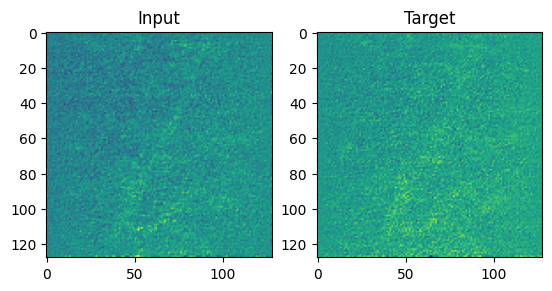

In [ ]:
path = '/content/gdrive/MyDrive/CS445Final/2023-08-30-FullDataSet'
X = []
y = []
for ind, image_class in enumerate(os.listdir(path)):
    sameBaseImages = []
    image_path = os.path.join(path, image_class)
    tif = Image.open(image_path)
    for i in range(10): #only 10 instances per image.
        tif.seek(i)
        img = np.array(tif)
        sameBaseImages.append(img)

    #randomly match up different noise instances of the same image
    shuffled_images = sameBaseImages.copy()
    random.shuffle(shuffled_images)
    X.append(shuffled_images)
    y.append(sameBaseImages)
    if ind == 3: #create capture budget of only 4 images.
        break

X = np.array([item for row in X for item in row]) #flatten
y = np.array([item for row in y for item in row])
plt.subplot(121)
plt.imshow(X[0])
plt.title("Input")
plt.subplot(122)
plt.imshow(y[0])
plt.title("Target")
X = torch.from_numpy(X)
X = X.unsqueeze(1)
y = torch.from_numpy(y)
y = y.unsqueeze(1)
print("X and y shape: " ,X.shape , y.shape)

Now initialize and train. We will be using L2 loss (though you can chose other loss metrics), and Adam. An interesing aspect of Noise2Noise is that there is often no validation or test set because the training set output is actually what we want. The traning image outputs are denoised!

In [ ]:
model = UNet()
criterion = nn.MSELoss()
optim = Adam(model.parameters())
use_cuda = False
if torch.cuda.is_available():
    use_cuda = True
    model = model.cuda()
    criterion = criterion.cuda()
    X = X.cuda()
    y = y.cuda()

nb_epochs = 250
denoisedExamples = []
lossTrace = []

for epoch in range(nb_epochs):

    denoised = model(X)
    denoisedExamples.append(denoised)

    loss = criterion(denoised, y)

    optim.zero_grad()
    loss.backward()
    optim.step()
    lossTrace.append(loss.item())
    if epoch % 10 == 0:
      print('EPOCH {:d} / {:d}'.format(epoch + 1, nb_epochs) , "Loss: " , loss.item())

print("Training done.")

EPOCH 1 / 250 Loss:  0.29845336079597473
EPOCH 11 / 250 Loss:  0.054240882396698
EPOCH 21 / 250 Loss:  0.0514160580933094
EPOCH 31 / 250 Loss:  0.048928435891866684
EPOCH 41 / 250 Loss:  0.047724079340696335
EPOCH 51 / 250 Loss:  0.0469043031334877
EPOCH 61 / 250 Loss:  0.046384233981370926
EPOCH 71 / 250 Loss:  0.04599473997950554
EPOCH 81 / 250 Loss:  0.045712895691394806
EPOCH 91 / 250 Loss:  0.04553460702300072
EPOCH 101 / 250 Loss:  0.04540208354592323
EPOCH 111 / 250 Loss:  0.04528817534446716
EPOCH 121 / 250 Loss:  0.04519662261009216
EPOCH 131 / 250 Loss:  0.045131005346775055
EPOCH 141 / 250 Loss:  0.045083049684762955
EPOCH 151 / 250 Loss:  0.045046743005514145
EPOCH 161 / 250 Loss:  0.045003242790699005
EPOCH 171 / 250 Loss:  0.04496356472373009
EPOCH 181 / 250 Loss:  0.04492597654461861
EPOCH 191 / 250 Loss:  0.044932108372449875
EPOCH 201 / 250 Loss:  0.044871117919683456
EPOCH 211 / 250 Loss:  0.04482579603791237
EPOCH 221 / 250 Loss:  0.04478657618165016
EPOCH 231 / 250 

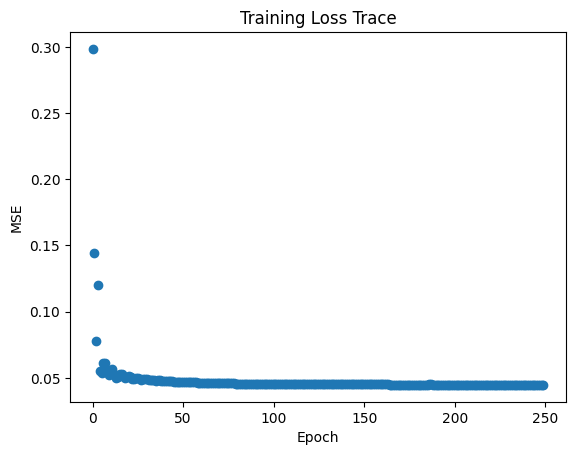

In [ ]:
plt.scatter(np.arange(nb_epochs), lossTrace)
plt.title('Training Loss Trace')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, .1)
plt.show()

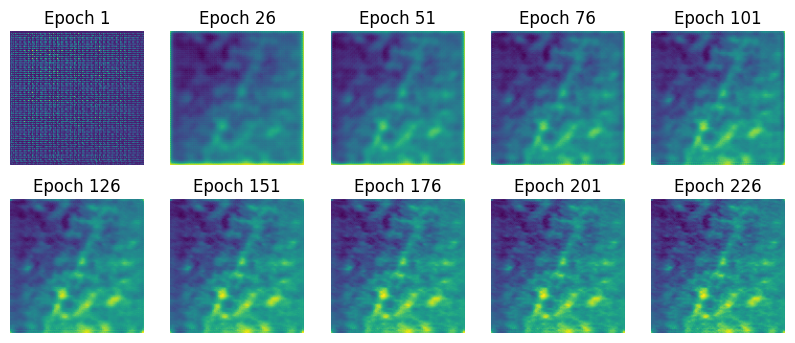

In [ ]:
rows, cols = (2,5)
plt.figure(figsize=(10,4))
for i in range(nb_epochs):
    if i % 25 == 0:
        plt.subplot(rows, cols, i// 25 + 1)
        plt.imshow(denoisedExamples[i].cpu().detach().numpy()[0].reshape(128,128))
        plt.title(f'Epoch {i+1}')
        plt.axis('off')

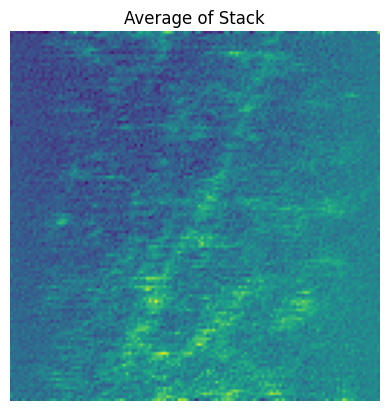

In [86]:
plt.imshow(a[0])
plt.title('Average of Stack')
plt.axis('off')
plt.show()

Noise2Noise does amazing. There is clearly underlying stucture that the model is finding. Unless the model completely memorizes the training set and ends up predicting the noisy target exactly, mathematically it has to be revealing true structure.

With a capture budget of 10 noisy instances for 4 images (40 total images), we can get very good denoising results. We do not need to know the noise distribution, the model learns it for us.

An issue with this method is inference on new images. That is what some of my research has to deal with, and is not something that I want to get into in this project.


#### Pros:
- Can use information from multiple images
- Excellent denoising.
- Versatile on many types of noise.
- Does not create artifacts or new structure (in most circumstances).
- Very few hyperparameters

#### Cons:
- Complex.
- Takes a good amount of time and is computationaly expensive.
- Using this for inference is difficult.
- *Requires* noisy image pairs (this is often impossible).

Noise2Noise provides confident predictions, is easy to use and understand (once you think about if for a while), and is hard to mess up. I will comment more on Noise2Noise is the conclusion.



---



---

### **Noise2Void**
[Krull et al., 2019]

As I mentioned, Noise2Noise has been built upon alot. Noise2Void is one of the most popular contributions to Noise2Noise, and I want to explore it.

The basic premise of Noise2Void is that the ground truth has underlying structure, and noise does not. Therefore we can predict the ground truth using the surrounding pixels and we cannot predict noise from the surrounding pixels. This method takes advantage of patch creation, like many other denoisers. Noise2Void 'blinds' the middle pixel of a patch of pixels, and uses the rest of the surrounding pixels to predict that blinded pixel.

![image.png](4-Figure2-1.png)

[Krull et al., 2019]

The framework only requires one image (not pairs) for denoising because it creates patches out of the images and those become the inputs and targets.

I will be using a tensor flow implementation for this because it was the only way I could find how to do it. I followed this tutorial https://github.com/bnsreenu/python_for_microscopists/blob/master/293_denoising_RGB_images_using_deep%20learning.ipynb and still struggled because of all of the moving parts. The training for this framework is a bit more involved, with the creation of patches and blinding pixels.

In [185]:
#Noise2Void tutorial taken from https://github.com/bnsreenu/python_for_microscopists/blob/master/293_denoising_RGB_images_using_deep%20learning.ipynb
datagen = N2V_DataGenerator()
imgs = datagen.load_imgs_from_directory('/content/gdrive/MyDrive/CS445Final/Png2',filter='*.png',dims='XY')
print('shape of loaded images: ', imgs[0].shape)

shape of loaded images:  (1, 128, 128, 1)


In [186]:
patch_size = 32
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)
Generated patches: (128, 32, 32, 1)


In [181]:
np.max(patches[0])

0.91764706

In [187]:
train_val_split = int(patches.shape[0] * 0.8)
X_patch = patches[:train_val_split]
X_val = patches[train_val_split:]

print(X_patch.shape)
print(X_val.shape)

(1843, 32, 32, 1)
(461, 32, 32, 1)


In [188]:
train_batch = 32
config = N2VConfig(X_patch, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X_patch.shape[0]/train_batch), train_epochs=100, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

In [189]:
model_name = 'n2vModel32'
basedir = '/content/gdrive/MyDrive/CS445Final'
model = N2V(config, model_name, basedir=basedir)

history = model.train(X_patch, X_val)

/usr/local/lib/python3.10/dist-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /content/gdrive/MyDrive/CS445Final/n2vModel32
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 461/461 [00:00<00:00, 7139.75it/s]

Epoch 1/100


 5/57 [=>............................] - ETA: 1s - loss: 2.0214 - n2v_mse: 2.0214 - n2v_abs: 1.1068

57/57 [==============================] - 10s 50ms/step - loss: 1.2380 - n2v_mse: 1.2380 - n2v_abs: 0.8616 - val_loss: 1.0978 - val_n2v_mse: 1.1045 - val_n2v_abs: 0.8492 - lr: 4.0000e-04
Epoch 2/100
57/57 [==============================] - 2s 42ms/step - loss: 0.8504 - n2v_mse: 0.8504 - n2v_abs: 0.7049 - val_loss: 0.8798 - val_n2v_mse: 0.8823 - val_n2v_abs: 0.7305 - lr: 4.0000e-04
Epoch 3/100
57/57 [==============================] - 2s 34ms/step - loss: 0.7648 - n2v_mse: 0.7648 - n2v_abs: 0.6723 - val_loss: 0.8481 - val_n2v_mse: 0.8522 - val_n2v_abs: 0.7116 - lr: 4.0000e-04
Epoch 4/100
57/57 [==============================] - 2s 31ms/step - loss: 0.7562 - n2v_mse: 0.7562 - n2v_abs: 0.6755 - val_loss: 0.8817 - val_n2v_mse: 0.8845 - val_n2v_abs: 0.7294 - lr: 4.0000e-04
Epoch 5/100
57/57 [==============================] - 2s 33ms/step - loss: 0.7011 - n2v_mse: 0.7011 - n2v_abs: 0.6465 - val_loss: 0.7806 - val_n2v_mse: 0.7772 - val_n2v_abs: 0.6585 - lr: 4.0000e-04
Epoch 6/100
57/57 [=======

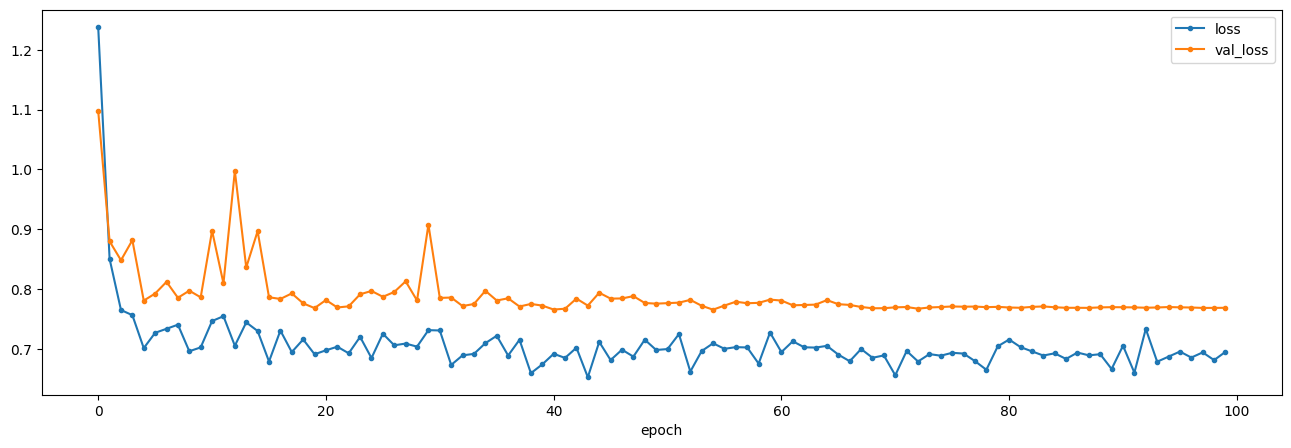

In [190]:
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

Loading network weights from 'weights_best.h5'.
1/1 [==============================] - 0s 299ms/step
MSE (denoised vs average):  1.03049


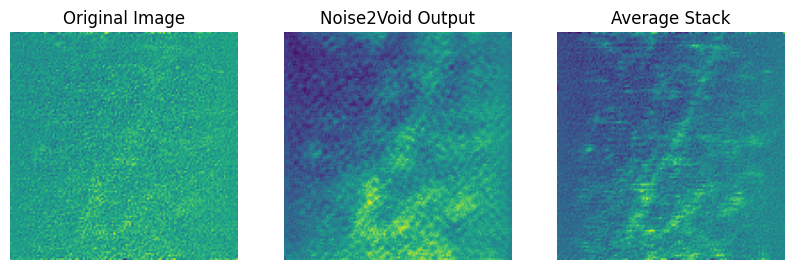

In [191]:
model_name = 'n2vModel32'
basedir = '/content/gdrive/MyDrive/CS445Final'
model = N2V(config=None, name=model_name, basedir=basedir)

from matplotlib.image import imread
img = imread('/content/gdrive/MyDrive/CS445Final/Png2/20230830_15_40_14.png')

pred = model.predict(img, axes='YX')
plot(X[0], pred, a[0], 'Noise2Void Output')

1/1 [==============================] - 0s 41ms/step
MSE (denoised vs average):  0.69177


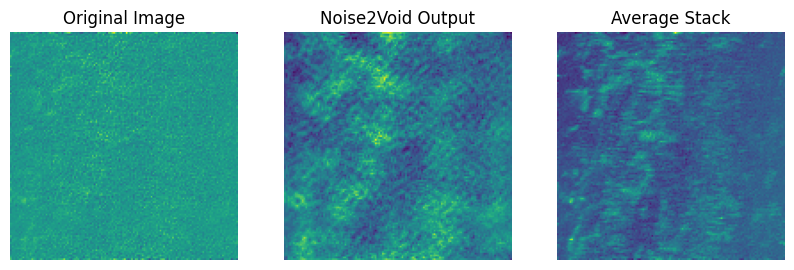

INFERNECE ON NEW IMAGE


In [194]:
img = imread('/content/gdrive/MyDrive/CS445Final/20230830_16_50_56.png')

pred = model.predict(img, axes='YX')
plot(X[-1], pred, a[-1], 'Noise2Void Output')
print("INFERNECE ON NEW IMAGE")

Noise2Void is certainly the most difficult denoiser to implement that we have seen so far. It was very hard to get it working. There is patch creation (which you have to hand pick the size of), and a ton of hyperparameters, which I mostly had no what to set them as. The model itself would have been impossible for me to build, and the data loading is quite complex as well. 

Even with the increased difficulty of understanding and implementing the model, I do believe this is something that is worthwile for people to look at, and is maybe something I will continue to look into. The idea is really smart and provides good results, epseicially on the training set. 

In the last code cell, I tried inference on a new image, and it did not do great.



---



---



###  **Some other Noise2Noise Variants**
*Neighbor2Neighbor*:
Loosens dataset constraint compared to Noise2Noise by only requiring one noisy image. An algorithm is used to seperate the image into 2 images for input and target. Then a Noise2Noise style network is trained with these new pairs. [Huang et al., 2021]


*Noise2Fast*:
Similar to Noise2Void (because masking), but is significantly lighter weight and faster. Also only requires one noisy image, not noisy pairs like Noise2Noise. This is a very popular framework. [Lequyer et a., 2022]


*ZeroShot Noise2Noise*
Continuation on Neighbor2Neighbor, emphasizing only using a single image for the entire learning process. [Mansour et al., 2023]


All of these variants are increasingly complex compared to Nosie2Noise. They all have their purpose and place, but for my purpose they are overly convoluded and complex, and provide very similar outputs to Noise2Noise from what I have seen.




---


---

# Conclusion

There is some serious validitity in using traditional/filter denoisers compared to deep learning. Very often you are only going to access to a single noisy image and require an instant denoiser. Traditional methods offer simple, quick and intuitive solutions. There is no need to set out a validation set, worry about overfitting, build a complicated model or dump a bunch of resources into GPUs and training. I saw especially promising results for my test images with the gaussian filter. I was really impressed with the results and I am definitely going to bring this method up in the lab. This also tells me that a gaussian distribution is a good approximation of my noise.

A huge drawback I noticed with traditional denoisers was the amount of hyperparameters, and how impactful they were to the denoising. This tells me that the traditional methods are not very flexible and they feel kind of unprincipled. Also they usually assume a particular type of noise, where deep learning methods may not.

I do think that if you do have access to noisy image stacks, Noise2Noise is going to be your best bet. It reveals structure very well, is consistent and can handle all different types of noise. Once you understand how it works, it is fairly easy to implement and use. There are not too many hyperparamters to chose from which was a huge bonus for me.

I was slightly underwhelmed by Noise2Void. I know that it is powerful and has its uses, but it just feels so overly engineered. There is also an absolutely ridiculous amount of hyperparameters. This anomicity toward Noise2Noise probably stems from the fact that I struggled with the implementation and didnt get great results...

A real downside of deep learning solutions is the huge leap in complexity. Not only does it require a ton of computational power, but it is also conceptually very difficult. This is a real downside for many people. Many different labs who are not expereinced in machine learning are looking for denoising. I find it hard to beleive that they would be able to implement most of these deep learning solutions.




---


---

# References

[Krull et al., 2019] Krull, A., Buchholz, T.-O., & Jug, F. (2019). Noise2Void - Learning Denoising from Single Noisy Images. arXiv.

[Lehtinen et al., 2018] Lehtinen, J., Munkberg, J., Hasselgren, J., Laine, S., Karras, T., Aittala, M., & Aila, T. (2018). Noise2Noise: Learning Image Restoration without Clean Data. Proceedings of the 35th International Conference on Machine Learning, Stockholm, Sweden, PMLR 80.

[Ronneberger et al., 2015] Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. Computer Science Department and BIOSS Centre for Biological Signalling Studies, University of Freiburg, Germany.


[Mansour et al., 2023] Mansour, Y., & Heckel, R. (2023). Zero-Shot Noise2Noise: Efficient Image Denoising without any Data. arXiv

[Lequyer et a., 2022] Lequyer, J., Philip, R., Sharma, A., & Pelletier, L. (2022). Noise2Fast: Fast Self-Supervised Single Image Blind Denoising. Nat Mach Intell, 4, 953-963. arXiv.

[Huang et al., 2021] Huang, T., Li, S., Jia, X., Lu, H., & Liu, J. (2021). Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images. arXiv.


[Fan et al., 2019] Fan, L., Zhang, F., Fan, H., & Zhang, C. (2019). Brief review of image denoising techniques. Visual Computing for Industry, Biomedicine, and Art, 2(7).


https://www.youtube.com/watch?v=71wqPyapFGU&t=997s

https://github.com/bnsreenu/python_for_microscopists/blob/master/293_denoising_RGB_images_using_deep%20learning.ipynb